<a href="https://colab.research.google.com/github/AlphardXyl/Algorithms-of-Foundation-Models/blob/main/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks

## 1. Introduction

Neural networks rely on training data to learn and improve their accuracy over time. However, once these learning algorithms are fine-tuned for accuracy, they are powerful tools in computer science and artificial intelligence, allowing us to classify and cluster data at a high velocity. Tasks in speech recognition or image recognition can take minutes versus hours when compared to the manual identification by human experts. One of the most well-known neural networks is Google’s search algorithm.

---
## 2. Application

### the Fashion MNIST Data Set


In [1]:
#!pip install tensorflow
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Use the keras module to import the necessary data
(train_X, train_y), (test_X, test_y) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [2]:
# This cell should be run inplace of the cell directly above
print(f"np.shape(train_X) ={np.shape(train_X)}")
print(f"np.shape(test_X) = {np.shape(test_X)} \n")

print(f"np.shape(train_X[0]) = {np.shape(train_X[0])}")
print(f"np.shape(test_X[0]) = {np.shape(test_X[0])} \n")

print(f"train_X[0] = {train_X[0]}")

np.shape(train_X) =(50000, 32, 32, 3)
np.shape(test_X) = (10000, 32, 32, 3) 

np.shape(train_X[0]) = (32, 32, 3)
np.shape(test_X[0]) = (32, 32, 3) 

train_X[0] = [[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


train_y[0] = array([6], dtype=uint8) 



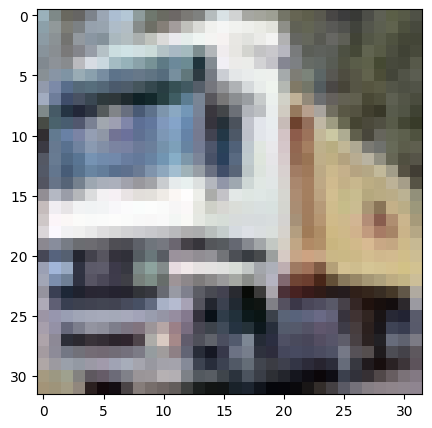

In [3]:
print(f"{train_y[0] = } \n")
plt.figure(figsize=(6, 5))
plt.imshow(train_X[1], cmap="gray")
plt.show()

In [4]:
# Scale the data for training.
train_X = train_X/255
test_X = test_X/255

# Flatten the training images into coloumn vectors.
flat_train_X = []
# One hot encode the training labels
onehot_train_y = []

for x, y in zip(train_X, train_y):
    flat_train_X.append(x.flatten().reshape(3072, 1))
    temp_vec = np.zeros((10, 1))
    temp_vec[y][0] = 1.0
    onehot_train_y.append(temp_vec)


# Do the same for the testing data
flat_test_X = []
onehot_test_y = []

for x, y in zip(test_X, test_y):
    flat_test_X.append(x.flatten().reshape(3072, 1))
    temp_vec = np.zeros((10, 1))
    temp_vec[y] = 1.0
    onehot_test_y.append(temp_vec)

---

### 2.1 Building the Network Architecture
For our purposes, we will build a multilayered **fully connected**, or **dense**, neural network with $L$ layers, $784$ input notes, $L-2$ hidden layers of arbitrary size, and $10$ output nodes.

For our activation function, we will use the sigmoid function:

* Sigmoid Function
$$
\sigma(z) = \frac{1}{1+e^{-z}}.
$$

For our cost function, we will use the Mean Sqaure Error cost:
$$
C(W, b) = \frac{1}{2}\sum_{k=1}^{10}(\hat{y}^{(i)}_k - y^{(i)}_k)^2.
$$

Our goal will be to write a custom Python class implementing our desired structure. However, before doing so, we first sequentually write functions to better understand the process of programming the following:

* Initializing the weights and biases of each layer
* The feedforward phase
* Calculation of the cost function
* Calculation of the gradient
* Iterating stochastic gradient descent

First we will define our sigmoid activation function, its derivative, and the mean squared error for a single instance of training data. Do this by running the following code.

---

In [5]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))

def mse(a, y):
    return .5*sum((a[i] - y[i])**2 for i in range(10))[0]

In [6]:
def initialize_weights(layers = [3072, 60, 60, 10]):
    # The following Python lists will contain numpy matrices
    # connected the layers in the neural network
    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):
        # The scalling factor is something I found in a research paper :)
        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])

        W.append(w_temp)
        B.append(b_temp)
    return W, B

---

### 2.2 Feedforward Phase

For $\ell = 1, \dots, L$, each layer $\ell$ in our network will have two phases, the preactivation phase $$\mathbf{z}^{\ell} = W^{\ell}\mathbf{a}^{\ell-1} + \mathbf{b}^{\ell},$$ and postactivation phase $$\mathbf{a}^{\ell} = \sigma(\mathbf{z}^{\ell}).$$ The preactivation phase consists of a weighted linear combination of postactivation values in the previous layer. The postactivation values consists of passing the preactivation value through an activation function elementwise. Note $\mathbf{a}^0 = \mathbf{x}^{(i)}$, where $\mathbf{x}^{(i)}$ is the current input data into our network.

We can test our activation functions and matrix dimensions by running the following code which manually implements the feedforward process on a neural network with the given dimensions.

---

In [7]:
W, B = initialize_weights()

xi = flat_train_X[0]
yi = onehot_train_y[0]
a0 = xi

print(f"np.shape(a0) = {np.shape(a0)} \n")

z1 = W[1] @ a0 + B[1]
a1 = sigmoid(z1)

print(f"np.shape(W[1]) = {np.shape(W[1])}")
print(f"np.shape(z1) = {np.shape(z1)}")
print(f"np.shape(a1) = {np.shape(a1)} \n")

z2 = W[2] @ a1 + B[2]
a2 = sigmoid(z2)

print(f"np.shape(W[2]) = {np.shape(W[2])}")
print(f"np.shape(z2) = {np.shape(z2)}")
print(f"np.shape(a2) = {np.shape(a2)} \n")

z3 = W[3] @ a2 + B[3]
a3 = sigmoid(z3)
y_hat = a3
print(f"np.shape(W[3]) = {np.shape(W[3])}")
print(f"np.shape(z3) = {np.shape(z3)}")
print(f"np.shape(a3) = {np.shape(a3)} \n")


print(f"Prediction: np.argmax(y_hat) = {np.argmax(y_hat)}")
print(f"Target Label: np.argmax(yi) = {np.argmax(yi)}")
print(f"mse(y_hat, yi) = {mse(y_hat, yi)}")

np.shape(a0) = (3072, 1) 

np.shape(W[1]) = (60, 3072)
np.shape(z1) = (60, 1)
np.shape(a1) = (60, 1) 

np.shape(W[2]) = (60, 60)
np.shape(z2) = (60, 1)
np.shape(a2) = (60, 1) 

np.shape(W[3]) = (10, 60)
np.shape(z3) = (10, 1)
np.shape(a3) = (10, 1) 

Prediction: np.argmax(y_hat) = 3
Target Label: np.argmax(yi) = 0
mse(y_hat, yi) = 1.0098900839011398


In [8]:
def forward_pass(W, B, xi, predict_vector = False):
    Z = [[0.0]]
    A = [xi]
    L = len(W) - 1
    for i in range(1, L + 1):
        z = W[i] @ A[i-1] + B[i]
        Z.append(z)

        a = sigmoid(z)
        A.append(a)

    if predict_vector == False:
        return Z, A
    else:
        return A[-1]

def predict(W, B, xi):
    _, A = forward_pass(W, B, xi)
    return np.argmax(A[-1])

y_hat = forward_pass(W, B, flat_train_X[0], predict_vector=True)
print(f"Prediction: np.argmax(y_hat) = {np.argmax(y_hat)}")
print(f"Target Label: np.argmax(yi) = {np.argmax(yi)}")
print(f"mse(y_hat, yi) = {mse(y_hat, yi)}")

Prediction: np.argmax(y_hat) = 3
Target Label: np.argmax(yi) = 0
mse(y_hat, yi) = 1.0098900839011398


In [9]:

def random_experiment(W, B, data_features, data_labels):
    i = np.random.randint(len(data_features))
    print(f"Actual label: {np.argmax(data_labels[i])}")
    print(f"Predicted label: {predict(W, B, data_features[i])}")


def MSE(W, B, X, y):
    cost = 0.0
    m = 0
    for xi, yi in zip(X, y):
        a = forward_pass(W, B, xi, predict_vector = True)
        cost += mse(a, yi)
        m+=1
    return cost/m

In [10]:
print(f"MSE(W, B, flat_train_X, onehot_train_y) = {MSE(W, B, flat_train_X, onehot_train_y)} \n")

random_experiment(W, B, flat_train_X, onehot_train_y)

MSE(W, B, flat_train_X, onehot_train_y) = 1.0090856545932843 

Actual label: 0
Predicted label: 3


---

### 2.3 Backpropogation Phase with Stochastic Gradient Descent
We are now ready to define a custom Python ```DenseNetwork``` class which initializes the weights and bias for the network, and implements stochastic gradient descent shown below:

1. For each $i = 1, \dots, N$.
2. Feedforward $\mathbf{x}^{(i)}$ into the network.
3. Compute $\delta^{L} = \nabla_aC\otimes \sigma'(\mathbf{z}^{L})$.
4. For $\ell = L-1, \dots, 1$, compute $\delta^{\ell} = \big ( (\mathbf{w}^{\ell + 1})^{T} \delta^{\ell + 1} \Big )\otimes \sigma'(\mathbf{z}^{\ell})$.
5. For $\ell = L, L-1, \dots, 1$,

$$
w^{\ell} \leftarrow w^{\ell} - \alpha \delta^{\ell}(\mathbf{a}^{\ell-1})^{T}
$$

$$
b^{\ell} \leftarrow b^{\ell} - \alpha \delta^{\ell}
$$


---

In [11]:

class DenseNetwork(object):
    def __init__(self, layers = [3072, 60, 60, 10]):
        self.layers = layers
        self.W, self.B = initialize_weights(layers = self.layers)

    def train(self, X_train, y_train, alpha = 0.046, epochs = 4):
        # Print the initial mean squared error
        self.errors_ = [MSE(self.W, self.B, X_train, y_train)]
        print(f"Starting Cost = {self.errors_[0]}")

        # Find your sample size
        sample_size = len(X_train)

        # Find the number of non-input layers.
        L = len(self.layers) - 1

        # For each epoch perform stochastic gradient descent.
        for k in range(epochs):
            # Loop over each (xi, yi) training pair of data.
            for xi, yi in zip(X_train, y_train):
                # Use the forward pass function defined before
                # and find the preactivation and postactivation values.
                Z, A = forward_pass(self.W, self.B, xi)

                # Store the errors in a dictionary for clear interpretation
                # of computation of these values.
                deltas = dict()

                # Compute the output error
                output_error = (A[L] - yi)*d_sigmoid(Z[L])
                deltas[L] = output_error

                # Loop from L-1 to 1. Recall the right entry of the range function
                # is non-inclusive.
                for i in range(L-1, 0, -1):
                    # Compute the node errors at each hidden layer
                    deltas[i] = (self.W[i+1].T @ deltas[i+1])*d_sigmoid(Z[i])

                # Loop over each hidden layer and the output layer to perform gradient
                # descent.
                for i in range(1, L+1):
                    self.W[i] -= alpha*deltas[i] @ A[i-1].T
                    self.B[i] -= alpha*deltas[i]

            # Show the user the cost over all training examples
            self.errors_.append(MSE(self.W, self.B, X_train, y_train))
            print(f"{k + 1}-Epoch Cost = {self.errors_[-1]}")


    def predict(self, xi):
        depth = len(self.layers)
        _, A = forward_pass(self.W, self.B, xi)
        return np.argmax(A[-1])

MSE(net.W, net.B, flat_train_X, onehot_train_y) = 1.4734776834525998 

predicted digit is: 1
actual digit is: 3


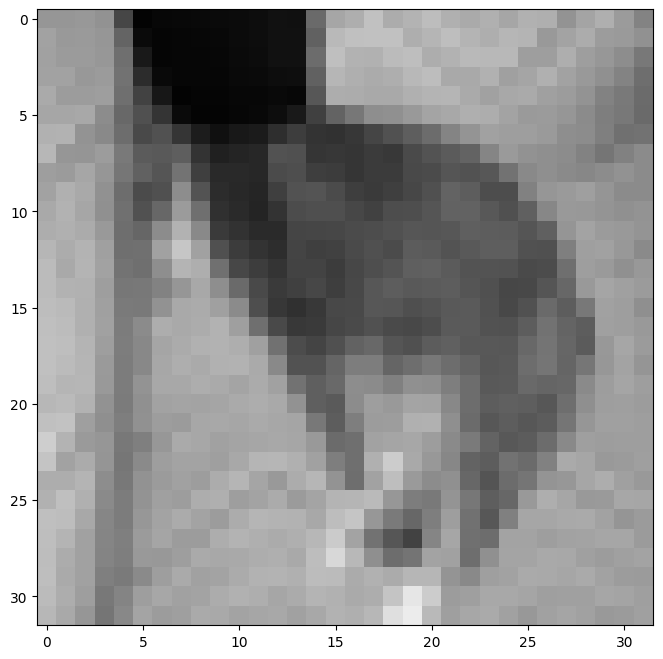

In [12]:
# Initialize a network with 3072 input nodes, two hidden layers with 60 nodes each
# and a output layer with 10 nodes.
net = DenseNetwork(layers = [3072, 120, 145, 120, 10])

# Check the mean squared error before training
print(f"MSE(net.W, net.B, flat_train_X, onehot_train_y) = {MSE(net.W, net.B, flat_train_X, onehot_train_y)} \n")

# Make a random prediction before training
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

In [ ]:
# Train your network with stochastic gradient descent!
net.train(flat_train_X, onehot_train_y)

Starting Cost = 1.4734776834525998
1-Epoch Cost = 1.7723379161897683e-05
2-Epoch Cost = 8.58145991848685e-06


In [ ]:
# Visualize the mean squared error over the training process
plt.figure(figsize = (10, 8))
epochs = range(len(net.errors_))
plt.plot(epochs, net.errors_, marker = "o")
plt.xticks(epochs)
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.title("Network MSE During Training", fontsize = 16)
plt.show()


In [ ]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

In [ ]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

In [ ]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

### 2.4 Classification Error

In [ ]:
# Compute the classification accuracy of our trained model on the test data (I bet we did well!)
sum([int(net.predict(x) == y) for x, y in zip(flat_test_X, test_y)])/len(onehot_test_y)

In [ ]:
import torch
torch.save(net,'my_nn.pt')

x=torch.randn((3072,1))
torch.onnx.export(net, # 搭建的网络
    x, # 输入张量
    'my_nn.onnx')

In [ ]:
model = torch.load('my_nn.pt')
testM = np.random.rand(32,32,3)
flat_testM = testM.flatten().reshape(3072, 1)
prediction = model.predict(flat_testM)

In [ ]:
i = np.random.randint(0, len(flat_test_X))
prediction = model.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()